In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sys
sys.path.append('../codes')
import utils.hyperbolic_utils as hyp


# Load model and data

In [2]:
ckpt_path = '../models/RotatE_wn18rr_0/checkpoint/ckpt_79999'
data_path = '../data/wn18rr'
dataset = 'wn18rr'
hyperbolic = False

# ckpt_path = '../models/RotatE_wn18_0/checkpoint'
# data_path = '../data/wn18'
# dataset = 'wn18'
# hyperbolic = False

# ckpt_path = '../models/RotatE_FB15k_0/checkpoint/ckpt_149999'
# data_path = '../data/FB15k'
# dataset = 'FB15k'
# hyperbolic = False

# ckpt_path = '../models/RotatTransH_wn18rr_0/checkpoint/ckpt_29999'
# data_path = '../data/wn18rr'
# dataset = 'wn18rr'
# hyperbolic = True


In [3]:
print('Loading checkpoint %s...' % ckpt_path)
checkpoint = torch.load(ckpt_path, map_location='cpu')
entity_embedding = checkpoint['model_state_dict']['entity_embedding']
relation_embedding = checkpoint['model_state_dict']['relation_embedding']
embedding_range = checkpoint['model_state_dict']['embedding_range']
if hyperbolic:
    curvature = checkpoint['model_state_dict']['curvature']
    curvature = torch.nn.Softplus()(curvature)
    print('curvature is %f' % curvature)
    

Loading checkpoint ../models/RotatE_wn18rr_0/checkpoint/ckpt_79999...


In [4]:
def read_triple(file_path, entity2id, relation2id):
    '''
    Read triples and map them into ids.
    '''
    triples = []
    with open(file_path) as fin:
        for line in fin:
            h, r, t = line.strip().split('\t')
            triples.append((entity2id[h], relation2id[r], entity2id[t]))
    return triples

with open(os.path.join(data_path, 'entities.dict')) as fin:
    entity2id = dict()
    for line in fin:
        eid, entity = line.strip().split('\t')
        entity2id[entity] = int(eid)

with open(os.path.join(data_path, 'relations.dict')) as fin:
    relation2id = dict()
    for line in fin:
        rid, relation = line.strip().split('\t')
        relation2id[relation] = int(rid)

train_triples = read_triple(os.path.join(data_path, 'train.txt'), entity2id, relation2id)
train_triples = torch.LongTensor(train_triples)
triples = train_triples

rid2cid = dict()
category2id = {'1-1': 0, '1-M': 1, 'M-1': 2, 'M-M': 3, 'None': -1}

with open(os.path.join(data_path, 'relation_category.txt')) as fin:
    for line in fin:
        relation, category = line.strip().split('\t')
        rid2cid[relation2id[relation]] = category2id[category]


# Calculate branching factor

In [ ]:
relation_id = 4

# Search for 1-to-N

In [43]:
mode = '1-to-N'
relation_id = 8
mask = torch.nonzero(triples[:, 1] == relation_id).squeeze(1)
print(mask.shape[0])
bincount = torch.bincount(triples[mask, 0])
print(torch.max(bincount).item(), torch.argmax(bincount).item(), bincount.shape[0], mask.shape[0])
entity_id = torch.argmax(bincount).item()
mask = (triples[:, 1] == relation_id) * (triples[:, 0] == entity_id)
print(torch.nonzero(mask).shape[0])


923
442 785 37899 923
442


# Search for N-to-1

In [21]:
mode = 'N-to-1'
relation_id = 5
mask = torch.nonzero(triples[:, 1] == relation_id).squeeze(1)
bincount = torch.bincount(triples[mask, 2])
print(torch.max(bincount).item(), torch.argmax(bincount).item(), bincount.shape[0], mask.shape[0])
entity_id = torch.argmax(bincount).item()
mask = (triples[:, 1] == relation_id) * (triples[:, 2] == entity_id)
print(torch.nonzero(mask).shape[0])


339 172 40374 3116
339


FB15k 1-N: (310, 8644), (13547,360)

FB15k N-1: (381, 13062)


In [36]:
pi = 3.14159265358979323846

entity_id = 785
relation_id = 7
mode = '1-to-N'

if mode == '1-to-N':
    mask = (triples[:, 0] == entity_id) * (triples[:, 1] == relation_id)
    nonzero = torch.nonzero(mask).squeeze(1)
    tail_id = train_triples[nonzero, 2]
    print(mode, entity_id, relation_id, tail_id.shape[0])

    head = entity_embedding[entity_id, :].unsqueeze(0)
    tails = entity_embedding[tail_id, :]
    relation = relation_embedding[relation_id, :]

elif mode == 'N-to-1':
    mask = (triples[:, 1] == relation_id) * (triples[:, 2] == entity_id) 
    nonzero = torch.nonzero(mask).squeeze(1)
    head_id = train_triples[nonzero, 0]
    print(mode, entity_id, relation_id, head_id.shape[0])

    head = entity_embedding[head_id, :]
    tails = entity_embedding[entity_id, :].unsqueeze(0)
    relation = relation_embedding[relation_id, :]
else:
    raise ValueError('mode %s not supported' % mode)


# print(head.shape, relation.shape)
# head = head[:, 0:500]
# tails = tails[:, 0:500]
re_head, im_head = torch.chunk(head, 2, dim=1)
re_tail, im_tail = torch.chunk(tails, 2, dim=1)


phase_relation = relation/(embedding_range.item()/pi)
re_relation = torch.cos(phase_relation)
im_relation = torch.sin(phase_relation)

re_score = re_head * re_relation - im_head * im_relation
im_score = re_head * im_relation + im_head * re_relation

score = torch.stack([re_score, im_score], dim = 0)

diff = (re_tail - score[0]) ** 2 + (im_tail - score[1]) ** 2
print(diff.shape)



1-to-N 785 7 14
torch.Size([14, 500])


# Visualize points

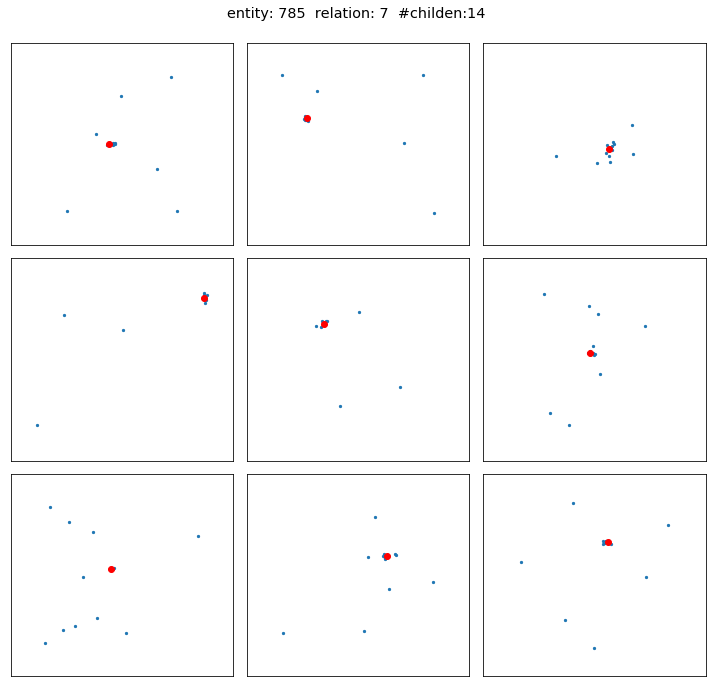

In [38]:
fig = plt.figure(figsize=(10, 10), frameon=False)
N = 3
markersize=5.0

st = fig.suptitle("entity: %d  relation: %d  #childen:%d" % (entity_id, relation_id, tail_id.shape[0]), fontsize="x-large")


for i in range(N ** 2):
    dim = i
    plt.subplot(N, N, i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    if mode == '1-to-N':
        plt.scatter(re_tail[:, dim], im_tail[:, dim], s=markersize)
        plt.scatter(re_score[:, dim], im_score[:, dim], color='red')
    else:
        # plt.scatter(re_head[:, dim], im_head[:, dim], s=markersize, color='green')
        plt.scatter(re_score[:, dim], im_score[:, dim], s=markersize)
        plt.scatter(re_tail[:, dim], im_tail[:, dim], color='red')

fig.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.90)

fig.savefig("./figures/%s_e_%d_r_%d_childen_%d.png" % (dataset, entity_id, relation_id, tail_id.shape[0]))


# Visualize testing results

In [5]:
hits_path = '../models/RotatE_FB15k_0/hits.pkl'
file = open(hits_path, 'rb')
hits = pickle.load(file)
file.close()

In [72]:
criteria = {
    'category': 1,
    'mode': 'tail-batch'
}
fulfil = []
for i in range(len(hits)):
    hit = hits[i]
    if True:# hit['ranking'] >= 6000: # 1: #> ranking_thresh:
        match = True
        for key in criteria.keys():
            match = match and (criteria[key] == hit[key])

        if match:
            fulfil.append(hit)
            # ranking = hit['ranking']
            # score = 1 if ranking <= 3 else 0

divide = 20
N = int(300 / divide)
scores = np.zeros(N)
count = np.zeros(N)

num = []
rankings = []
# count = 0
for hit in fulfil:
    pos = hit['positive']
    mask = torch.nonzero((triples[:, 1] == pos[1]) & (triples[:, 0] == pos[0])).squeeze(1)
    ranking = hit['ranking']
    num.append(mask.shape[0])
    rankings.append(1.0 / ranking)

    score = 1.0 / ranking
    
    index = mask.shape[0] // divide
    if index < N:
        # print(mask.shape[0], index)
        scores[index] += score
        count[index] += 1

scores = scores / (count + 1e-15)
   
 

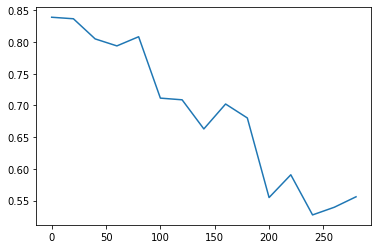

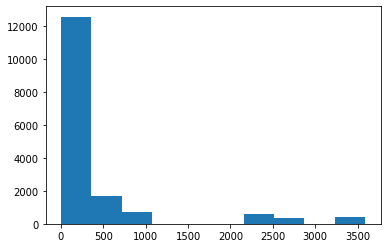

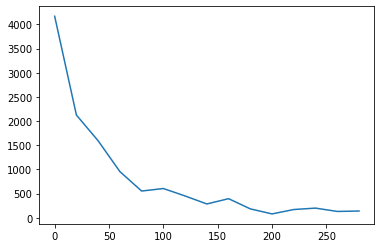

In [73]:
# plt.scatter(np.asarray(num), np.asarray(rankings), s=1.)


plt.plot(np.arange(N) * divide, scores)
plt.show()
plt.hist(num)
plt.show()
plt.plot(np.arange(N) * divide, count)

# Search hits

In [24]:
ranking_thresh = 100
criteria = {
    'category': 1,
    'mode': 'tail-batch'
}
fulfil = []
for i in range(len(hits)):
    hit = hits[i]
    if hit['ranking'] >= 6000: # 1: #> ranking_thresh:
        match = True
        for key in criteria.keys():
            match = match and (criteria[key] == hit[key])

        if match:
            fulfil.append(i)

new_fulfil = []
for i in fulfil:
    pos = hits[i]['positive']
    mask = torch.nonzero((triples[:, 1] == pos[1]) & (triples[:, 0] == pos[0])).squeeze(1)
    # print(mask.shape)
    if mask.shape[0] > 10:
        new_fulfil.append(i)
        print(i, mask.shape[0], pos)
fulfil = new_fulfil
    

    

61402 405 tensor([ 968,  716, 2268])
61459 69 tensor([2704,  310,  778])
62048 411 tensor([7610,  524, 1005])
63818 3590 tensor([8794,  870, 4082])
67897 3590 tensor([8794,  870, 5569])
73623 2337 tensor([14546,   870,  9740])
75357 405 tensor([  968,   716, 12984])
75768 3590 tensor([8794,  870, 3023])
81579 3590 tensor([8794,  870, 8494])
81581 3590 tensor([8794,  870, 1906])
85313 2337 tensor([14546,   870,  5178])
85321 2337 tensor([14546,   870,  3592])
85951 241 tensor([12137,   822, 14422])
89440 3590 tensor([8794,  870, 8914])
91773 49 tensor([ 1895,   822, 11403])
96845 405 tensor([ 968,  716, 1495])
97089 2337 tensor([14546,   870,  5360])
97275 3590 tensor([ 8794,   870, 10357])
97280 3590 tensor([8794,  870, 2547])
103400 411 tensor([7610,  524, 4884])
104934 2337 tensor([14546,   870,  8534])
107158 3590 tensor([ 8794,   870, 12213])
109153 3590 tensor([8794,  870, 3329])
110799 25 tensor([5590,  822,  526])
110933 2337 tensor([14546,   870,  2695])


In [25]:
indices = np.random.choice(fulfil, 20, replace=False)
tail_train_scores = []
negative_samples_scores= []

print('Using Hyperbolic: ', hyperbolic)
for index in indices:
    
    hit = hits[index]
    # print(hit)
    mode = hit['mode']
    category = hit['category']
    head_id, relation_id, tail_id = hit['positive']
    top_five_id = hit['indices']
    ranking = hit['ranking']
    print('index: ', index, 'ranking: ', ranking)
    
    if hyperbolic:
        entity_dim = entity_embedding.shape[1]
        head = entity_embedding[head_id, 0:entity_dim-1].unsqueeze(0)
        tail = entity_embedding[tail_id, 0:entity_dim-1].unsqueeze(0)
        top_five = entity_embedding[top_five_id, 0:entity_dim-1]
        bh = entity_embedding[head_id, entity_dim-1].unsqueeze(0)
        bt = entity_embedding[tail_id, entity_dim-1].unsqueeze(0)
        b_top_five = entity_embedding[top_five_id, entity_dim-1]
        relation = relation_embedding[relation_id, :]
        
        head = hyp.proj(hyp.expmap0(head, curvature), c=curvature)
        tail = hyp.proj(hyp.expmap0(tail, curvature), c=curvature)
        top_five = hyp.proj(hyp.expmap0(top_five, curvature), c=curvature)
    else:
        head = entity_embedding[head_id, :].unsqueeze(0)
        tail = entity_embedding[tail_id, :].unsqueeze(0)
        relation = relation_embedding[relation_id, :]
        top_five = entity_embedding[top_five_id, :]

    re_head, im_head = torch.chunk(head, 2, dim=1)
    re_tail, im_tail = torch.chunk(tail, 2, dim=1)
    re_top_five, im_top_five = torch.chunk(top_five, 2, dim=1)

    pi = 3.14159265358979323846
    
    
    if relation.shape[0] == re_head.shape[1]:
        phase_relation = relation/(embedding_range.item()/pi)
        translation_flag = False
    else:
        print('Using translation ...')
        phase_relation, translation = relation.split([int((entity_dim-1)/2.),entity_dim-1], dim=0)
        phase_relation = phase_relation / (embedding_range.item() / pi)
        translation = hyp.proj(hyp.expmap0(translation, curvature), c=curvature)
        translation_flag = True
        
    re_relation = torch.cos(phase_relation)
    im_relation = torch.sin(phase_relation)

    if mode == 'head-batch':
        raise NotImplementedError('Not implemented for hyperbolic case')
        re_predicted = re_relation * re_tail + im_relation * im_tail
        im_predicted = re_relation * im_tail - im_relation * re_tail
    else:
        re_predicted = re_head * re_relation - im_head * im_relation
        im_predicted = re_head * im_relation + im_head * re_relation


    if category in [0, 1]:
        mask = (triples[:, 0] == head_id) * (triples[:, 1] == relation_id)
        nonzero = torch.nonzero(mask).squeeze(1)
        tail_id = train_triples[nonzero, 2]
        
        if hyperbolic:
            tails_train = entity_embedding[tail_id, 0:entity_dim-1]
            b_tails_train = entity_embedding[tail_id, entity_dim-1]
            tails_train = hyp.proj(hyp.expmap0(tails_train, curvature), c=curvature)
        else:
            tails_train = entity_embedding[tail_id, :]
            re_tail_train, im_tail_train = torch.chunk(tails_train, 2, dim=1)
        
    elif category == 2:
        # N-to-1
        raise NotImplementedError
        mask = (triples[:, 1] == relation_id) * (triples[:, 2] == tail_id) 
        nonzero = torch.nonzero(mask).squeeze(1)
        head_id = train_triples[nonzero, 0]
        heads = entity_embedding[head_id, :]
        re_head_train, im_head_train = torch.chunk(heads, 2, dim=1)
        re_tail_train = re_head_train * re_relation - im_head_train * im_relation
        im_tail_train = re_head_train * im_relation + im_head_train * re_relation

    else:
        raise ValueError('mode %s not supported' % mode)

    # print('Tails in train triples: ', re_tail_train.shape)

    
    # Negative samples
    filter_bias = hit['filter_bias'].tolist()
    negative_sample_id = [i for i in range(entity_embedding.shape[0]) if i not in filter_bias]
    
    if hyperbolic:
        negative_samples = entity_embedding[negative_sample_id, 0:entity_dim-1]
        b_negative_samples = entity_embedding[negative_sample_id, entity_dim-1]
        negative_samples = hyp.proj(hyp.expmap0(negative_samples, curvature), c=curvature)
    else:
        negative_samples = entity_embedding[negative_sample_id, :]
    
    if hyperbolic:
        predicted = torch.cat([re_predicted, im_predicted], dim=1)
        
        if translation_flag:
            predicted = hyp.proj(predicted, c=curvature)
            predicted = hyp.mobius_add(predicted, translation, curvature)
            
        predicted = hyp.proj(predicted, c=curvature)
        
        
#         s1 = bh + b_tails_train - hyp.sqdist(predicted, tails_train, curvature)
#         s2 = bh + b_negative_samples - hyp.sqdist(predicted, negative_samples, curvature)
        
        s1 = hyp.sqdist(predicted, tails_train, curvature)
        s2 = hyp.sqdist(predicted, negative_samples, curvature)
        tail_train_scores.append(s1)
        negative_samples_scores.append(s2)
     
    else:  # Euclidean case
        re_negative_samples, im_negative_samples = torch.chunk(negative_samples, 2, dim=1)
        re_tail_train_score = re_tail_train - re_predicted
        im_tail_train_score = im_tail_train - im_predicted
        re_negative_samples_score = re_negative_samples - re_predicted
        im_negative_samples_score = im_negative_samples - im_predicted

        re_tail_score = re_tail - re_predicted
        im_tail_score = im_tail - im_predicted


        tail_train_scores.append(torch.stack([re_tail_train_score, im_tail_train_score], dim=0).norm(p=2, dim=0).sum(dim=-1))
        negative_samples_scores.append(torch.stack([re_negative_samples_score, im_negative_samples_score], dim=0).norm(p=2, dim=0).sum(dim=-1))
        # tail_test_score = torch.stack([re_tail_score, im_tail_score], dim=0).norm(p=2, dim=0))

    

    # print(tail_test_score, negative_samples_scores[-1].min())
    
tail_train_scores = torch.cat(tail_train_scores)
negative_samples_scores = torch.cat(negative_samples_scores)

Using Hyperbolic:  False
index:  81581 ranking:  8548
index:  104934 ranking:  6235
index:  67897 ranking:  10514
index:  107158 ranking:  6521
index:  97275 ranking:  6509
index:  91773 ranking:  6619
index:  73623 ranking:  7114
index:  85313 ranking:  6822
index:  110799 ranking:  13742
index:  85951 ranking:  14369
index:  103400 ranking:  14419
index:  97089 ranking:  7792
index:  96845 ranking:  14070
index:  75357 ranking:  8844
index:  81579 ranking:  8981
index:  97280 ranking:  10542
index:  85321 ranking:  11647
index:  89440 ranking:  8904
index:  61402 ranking:  9964
index:  109153 ranking:  6032


torch.Size([42346]) torch.Size([247368])


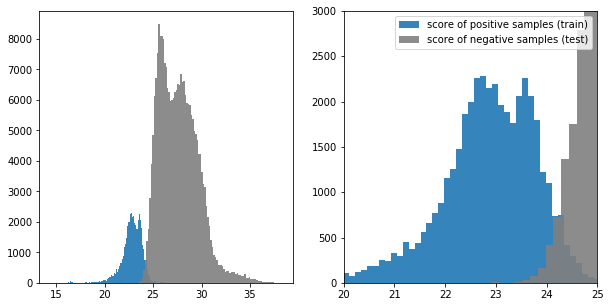

tensor([0.0235])
tensor(22.9056)


In [28]:
print(tail_train_scores.shape, negative_samples_scores.shape)
fig = plt.figure(figsize=(10, 5), frameon=False)
plt.subplot(121)
plt.hist(tail_train_scores, 100, alpha=0.9, label='score of positive samples (train)')
plt.hist(negative_samples_scores, 100, alpha=0.9, label='score of negative samples (test)', color='gray')
# plt.legend(loc='upper right')
plt.subplot(122)
plt.hist(tail_train_scores, 100, alpha=0.9, label='score of positive samples (train)')
plt.hist(negative_samples_scores, 100, alpha=0.9, label='score of negative samples (test)', color='gray')
# plt.axvline(x=tail_test_score, color='red', label='score of positive sample (test)')
plt.xlim([20, 25])
plt.ylim([0, 3000])
plt.legend(loc='upper right')


if hyperbolic:
    plt.savefig('./figures/%s_hyperbolic.jpg' % dataset)
else:
    plt.savefig('./figures/%s_ranking_6000.jpg' % dataset)
plt.show()

print(tail_test_score)
print(torch.min(negative_samples_scores))



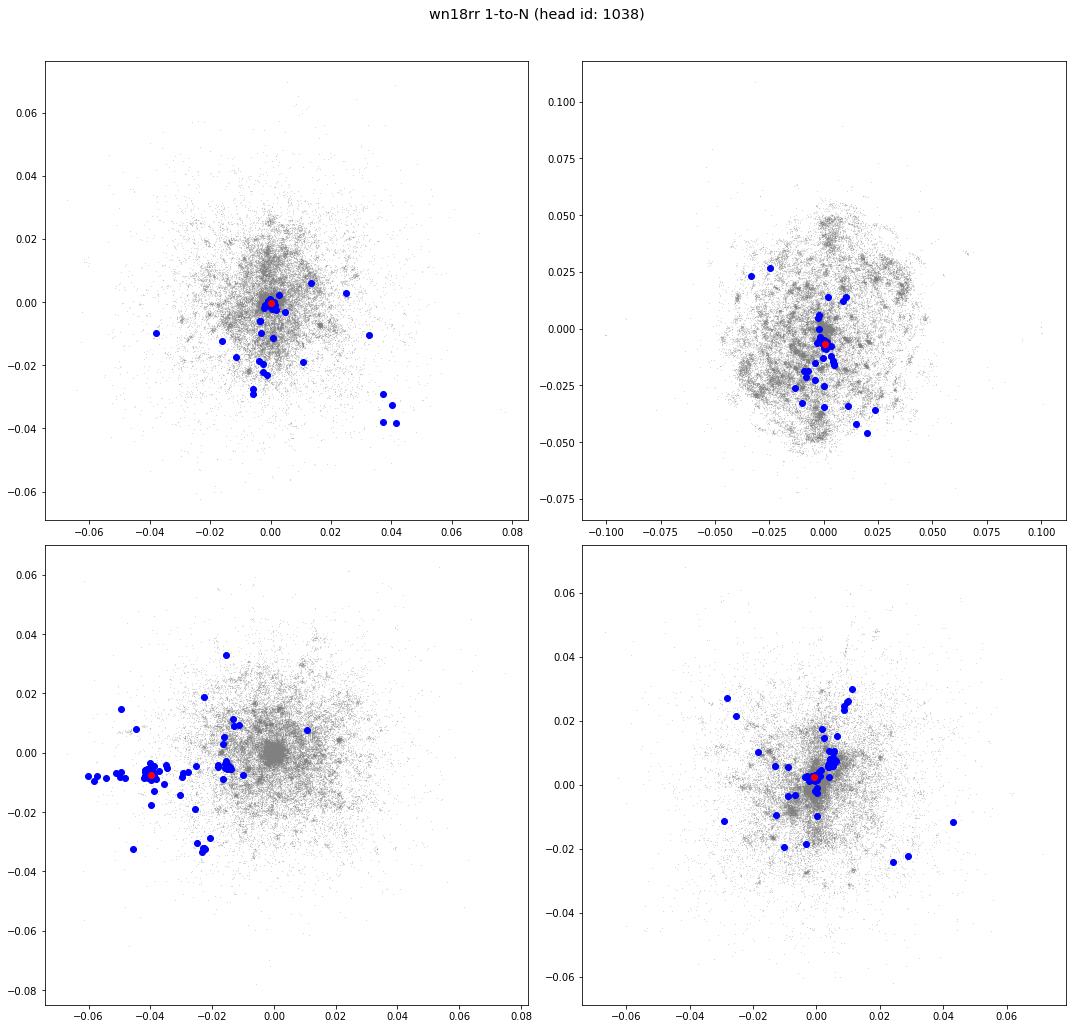

In [14]:


fig = plt.figure(figsize=(15, 15), frameon=False)
N = 2
markersize=1.0
st = fig.suptitle("%s 1-to-N (head id: %d)" % (dataset, head_id), fontsize="x-large")

n = [1, 2, 3, 4, 5]
for i in range(N ** 2):
    dim = np.random.randint(re_predicted.shape[1])
    plt.subplot(N, N, i+1)
#     plt.xticks([], [])
#     plt.yticks([], [])
    if mode == 'head-batch':
        plt.scatter(re_head[:, dim], im_head[:, dim], color='blue')
        plt.scatter(re_score[:, dim], im_score[:, dim], color='red')
        plt.scatter(re_top_five[:, dim], im_top_five[:, dim], color='green')
    else:
        plt.scatter(re_negative_samples[:, dim], im_negative_samples[:, dim], color='grey', s=0.01)
        plt.scatter(re_tail_train[:, dim], im_tail_train[:, dim], color='blue')
#         plt.scatter(re_top_five[:, dim], im_top_five[:, dim], color='green', s=50)
#         plt.scatter(re_tail[:, dim], im_tail[:, dim], color='blue')
        plt.scatter(re_predicted[:, dim], im_predicted[:, dim], color='red')
        
    
    # for j, txt in enumerate(n):
        # plt.annotate(txt, (re_top_five[j, dim], im_top_five[j, dim]))

fig.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.90)

fig.savefig("./figures/%s_e_%d_r_%d_childen_%d.png" % (dataset, head_id, relation_id, tail_id.shape[0]))


    

In [33]:

one_to_many = []
for i in range(len(relation2id)):
    if rid2cid[i] == 1:
        one_to_many.append(i)
print(one_to_many)

head_norm = []
num_children = []
pi = 3.14159265358979323846
entity_dim = 501

for j in range(len(one_to_many)):
    relation_id = one_to_many[j]
    mask = triples[:, 1] == relation_id
    heads = torch.unique(triples[torch.nonzero(mask), 0])

    for i in range(heads.shape[0]):
        mask = (triples[:, 1] == relation_id) & (triples[:, 0] == heads[i])
        m = torch.nonzero(mask).shape[0]
        if m > 1:
            head_embedding = entity_embedding[heads[i], 0:500].unsqueeze(0)
            head = hyp.proj(hyp.expmap0(head_embedding, curvature), c=curvature)
            re_head, im_head = torch.chunk(head, 2, dim=1)
            
            relation = relation_embedding[relation_id, :]
            phase_relation, translation = relation.split([int((entity_dim-1)/2.),entity_dim-1], dim=0)
            phase_relation = phase_relation / (embedding_range.item() / pi)
            re_relation = torch.cos(phase_relation)
            im_relation = torch.sin(phase_relation)
            translation = hyp.proj(hyp.expmap0(translation, curvature), c=curvature)
            
            re_predicted = re_head * re_relation - im_head * im_relation
            im_predicted = re_head * im_relation + im_head * re_relation
            
            predicted = torch.cat([re_predicted, im_predicted], dim=1)
    
            predicted = hyp.proj(predicted, c=curvature)
            predicted = hyp.mobius_add(predicted, translation, curvature)
            
            predicted = hyp.proj(predicted, c=curvature)
        
            print(predicted.shape)
            norm = predicted.norm(p=2, dim=1).item()
            head_norm.append(norm)
            num_children.append(m)
            print(norm, m)

[4, 6, 7, 8]
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000102519989014 3
torch.Size([1, 500])
1.0000089406967163 2
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
0.9869669675827026 3
torch.Size([1, 500])
1.0000096559524536 11
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.0000091791152954 8
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000100135803223 4
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000096559524536 7
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009536743164 11
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000088214874268 2
torch.Size([1, 500])
1

torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000091791152954 4
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745 5
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000096559524536 5
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.0000098943710327 4
torch.Size([1, 500])
1.0000096559524536 9
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000097751617432 

1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745 6
torch.Size([1, 500])
1.0000097751617432 5
torch.Size([1, 500])
1.0000097751617432 6
torch.Size([1, 500])
1.0000091791152954 5
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000101327896118 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000101327896118 4
torch.Size([1, 500])
1.0000094175338745 9
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000097751617432 4
torch.Size([1, 500])
1.0000096559524536 6
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000091791152954 5
torch.Size([1, 500]

torch.Size([1, 500])
1.0000090599060059 3
torch.Size([1, 500])
1.0000091791152954 5
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000096559524536 10
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000091791152954 6
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 5
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000098943710327 4
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000098943710327 6
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000091791152954 2
t

1.0000090599060059 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.0000097751617432 4
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009298324585 5
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000091791152954 4
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000097751617432 5
torch.Size([1, 500])
1

torch.Size([1, 500])
1.000009536743164 6
torch.Size([1, 500])
1.0000096559524536 5
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000094175338745 6
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000097751617432 4
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000097751617432 6
torch.Size([1, 500])
1.0000101327896118 5
torch.Size([1, 500])
1.0000098943710327 4
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000094175338745 2

torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000089406967163 3
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000100135803223 3
torch.Size([1, 500])
1.0000097751617432 6
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000096559524536 5
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.000009298324585 2

torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000091791152954 4
torch.Size([1, 500])
1.0000098943710327 4
torch.Size([1, 500])
1.0000100135803223 4
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.000009536743164 7
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000098943710327 4
torch.Size([1, 500])
1.0000100135803223 3
torch.Size([1, 500])
1.000009536743164 5
torch.Size([1, 500])
1.0000090599060059 3
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000100135803223 6
torch.Size([1, 500])
1.0000091791152954 3
torch.Size([1, 500])
1.0000098943710327 9
torch.Size([1, 500])
1.0000101327896118 2
torch.Size([1, 500])
1.000009536743164 

1.000009298324585 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000090599060059 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000097751617432 4
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 5
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000089406967163 3
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.0000098943710327 7
torch.Size([1, 500])
1

torch.Size([1, 500])
1.0000096559524536 5
torch.Size([1, 500])
1.000009536743164 6
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000010371208191 2
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.0000097751617432 4
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000094175338745 7
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000097751617432 4
torch.Size([1, 500])
1.0000100135803223 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000098943710327 2
t

torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000097751617432 7
torch.Size([1, 500])
1.000009298324585 5
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000101327896118 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000089406967163 3
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000091791152954 3
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000094175338745 6
torch.Size([1, 500])
1.000009775161743

torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000091791152954 6
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009536743164 8
torch.Size([1, 500])
0.9966667890548706 2
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 8
torch.Size([1, 500])
1.0000097751617432 5
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000097751617432 5
t

torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000101327896118 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000097751617432 5
torch.Size([1, 500])
1.0000100135803223 3
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000097751617432 5
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000096559524536 2
t

torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000097751617432 5
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000101327896118 8
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000098943710327 5
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.0000096559524536 8
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000094175338745 13
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000100135803223

torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000101327896118 2
torch.Size([1, 500])
1.0000094175338745 5
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000094175338745 6
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000101327896118 3
torch.Size([1, 500])
1.0000091791152954 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 7
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000097751617432 4
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000010371208191

torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.0000089406967163 6
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000101327896118 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000096559524536

torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000100135803223 3
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.0000097751617432 4
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000090599060059 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000098943710327 2

torch.Size([1, 500])
1.000009536743164 5
torch.Size([1, 500])
1.0000101327896118 2
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000096559524536 7
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.0000101327896118 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000089406967163 2
torch.Size([1, 500])
1.000009536743164 5
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000098943710327 7
to

torch.Size([1, 500])
1.0000100135803223 4
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000100135803223 4
torch.Size([1, 500])
1.0000094175338745 6
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.000009536743164 6
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000104904174805 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000101327896118 2
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000091791152954 2


0.9904118180274963 5
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000096559524536 7
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000097751617432 4
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])


torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000096559524536 6
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000090599060059 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000089406967163 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000101327896118 3
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000096559524536 5
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009775161743

torch.Size([1, 500])
1.0000090599060059 3
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000091791152954 7
torch.Size([1, 500])
1.0000098943710327 4
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000091791152954 4
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000098943710327 5
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000100135803223 4
torch.Size([1, 500])
1.0000094175338745 2
t

torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
0.9950600862503052 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000100135803223 3
torch.Size([1, 500])
1.0000098943710327 6
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000100135803223 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.00000953674316

torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.000009536743164 5
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000098943710327 4
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000100135803223 

1.0000098943710327 4
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000090599060059 3
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000090599060059 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000089406967163 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.

1.000009536743164 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000091791152954 3
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500]

torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000102519989014 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000101327896118 2
torch.Size([1, 500])
1.0000090599060059 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000101327896118 2
torch.Size([1, 500])
1.0000089406967163 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745

torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000091791152954 3
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000090599060059 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.0000091791152954 4
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000097751617432 4
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000091791152954 3
torch.Size([1, 500])
1.0000094175338745 

torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000101327896118 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000091791152954 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000090599060059 3
torch.Size([1, 500])
1.0000098943710327 4
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.00000989437103

torch.Size([1, 500])
1.0000090599060059 2
torch.Size([1, 500])
1.0000091791152954 3
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000096559524536 4
to

torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000101327896118 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000089406967163 2
torch.Size([1, 500])
1.000009298324585 4
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000096559524536 2
t

1.0000091791152954 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
0.9750804305076599 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000090599060059 2
torch.Size([1, 500])
1.000009298324585 3
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.

torch.Size([1, 500])
1.0000067949295044 2
torch.Size([1, 500])
1.0000070333480835 2
torch.Size([1, 500])
1.0000085830688477 3
torch.Size([1, 500])
1.0000076293945312 2
torch.Size([1, 500])
1.000006914138794 2
torch.Size([1, 500])
1.000007152557373 2
torch.Size([1, 500])
1.0000081062316895 2
torch.Size([1, 500])
1.0000072717666626 3
torch.Size([1, 500])
1.0000075101852417 2
torch.Size([1, 500])
1.000007152557373 2
torch.Size([1, 500])
1.0000070333480835 2
torch.Size([1, 500])
1.0000075101852417 3
torch.Size([1, 500])
1.0000078678131104 2
torch.Size([1, 500])
1.0000070333480835 2
torch.Size([1, 500])
1.0000077486038208 2
torch.Size([1, 500])
1.0000081062316895 2
torch.Size([1, 500])
1.0000076293945312 2
torch.Size([1, 500])
1.0000076293945312 2
torch.Size([1, 500])
1.0000078678131104 2
torch.Size([1, 500])
1.0000075101852417 2
torch.Size([1, 500])
1.0000075101852417 2
torch.Size([1, 500])
1.0000075101852417 2
torch.Size([1, 500])
1.0000078678131104 2
torch.Size([1, 500])
1.00000774860382

torch.Size([1, 500])
1.0000072717666626 2
torch.Size([1, 500])
1.0000076293945312 3
torch.Size([1, 500])
0.863243043422699 3
torch.Size([1, 500])
1.0000079870224 2
torch.Size([1, 500])
1.0000075101852417 2
torch.Size([1, 500])
1.0000077486038208 2
torch.Size([1, 500])
1.0000073909759521 2
torch.Size([1, 500])
1.0000075101852417 2
torch.Size([1, 500])
1.000008225440979 2
torch.Size([1, 500])
1.0000077486038208 2
torch.Size([1, 500])
1.0000075101852417 2
torch.Size([1, 500])
1.0000070333480835 2
torch.Size([1, 500])
1.0000070333480835 2
torch.Size([1, 500])
1.0000073909759521 2
torch.Size([1, 500])
1.0000072717666626 2
torch.Size([1, 500])
1.0000076293945312 2
torch.Size([1, 500])
1.000006914138794 2
torch.Size([1, 500])
1.0000075101852417 2
torch.Size([1, 500])
1.0000076293945312 2
torch.Size([1, 500])
1.0000077486038208 2
torch.Size([1, 500])
1.0000075101852417 2
torch.Size([1, 500])
1.0000081062316895 2
torch.Size([1, 500])
1.000007152557373 2
torch.Size([1, 500])
1.0000070333480835 2

torch.Size([1, 500])
1.0000083446502686 2
torch.Size([1, 500])
1.0000081062316895 4
torch.Size([1, 500])
1.0000081062316895 3
torch.Size([1, 500])
1.0000087022781372 3
torch.Size([1, 500])
0.8726358413696289 5
torch.Size([1, 500])
1.0000087022781372 2
torch.Size([1, 500])
1.000008225440979 3
torch.Size([1, 500])
1.000008225440979 3
torch.Size([1, 500])
1.000008463859558 3
torch.Size([1, 500])
1.000008463859558 3
torch.Size([1, 500])
1.000008463859558 2
torch.Size([1, 500])
1.0000081062316895 2
torch.Size([1, 500])
1.0000077486038208 3
torch.Size([1, 500])
1.0000087022781372 3
torch.Size([1, 500])
1.000008225440979 4
torch.Size([1, 500])
1.000008463859558 2
torch.Size([1, 500])
1.0000079870224 2
torch.Size([1, 500])
1.000008225440979 3
torch.Size([1, 500])
1.0000079870224 4
torch.Size([1, 500])
1.0000083446502686 3
torch.Size([1, 500])
1.0000085830688477 2
torch.Size([1, 500])
1.0000079870224 3
torch.Size([1, 500])
1.000008463859558 2
torch.Size([1, 500])
1.0000083446502686 3
torch.Size

1.000009536743164 4
torch.Size([1, 500])
1.0000090599060059 2
torch.Size([1, 500])
1.000009298324585 15
torch.Size([1, 500])
1.0000100135803223 14
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000101327896118 5
torch.Size([1, 500])
1.0000102519989014 5
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000100135803223 4
torch.Size([1, 500])
1.0000096559524536 3
torch.Size([1, 500])
1.0000094175338745 8
torch.Size([1, 500])
0.9927941560745239 19
torch.Size([1, 500])
1.0000098943710327 4
torch.Size([1, 500])
1.0000097751617432 7
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
0.9880616664886475 7
torch.Size([1, 500])
1.0000096559524536 4
torch.Size([1, 500])
1.0000096559524536 6
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000101327896118 6
torch.Size([1, 500])
1.0000098943710327 77
torch.Size([1, 500])
0.9813150763511658 7
torch.Size([1, 500])
1.0000098943710327 16
torch.Size([1, 500])
1.0000091791152954 2
torch.Size(

1.0000091791152954 2
torch.Size([1, 500])
0.997414231300354 2
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.0000097751617432 7
torch.Size([1, 500])
0.9856787919998169 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000098943710327 6
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
0.9647507667541504 7
torch.Size([1, 500])
1.0000098943710327 5
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000091791152954 3
torch.Size([1, 500])
1.0000097751617432 16
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000096559524536 7
torch.Size([1, 500])
1.0000101327896118 6
torch.Size([1, 500])
1.0000096559524536 13
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000101327896118 7
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000100135803223 3
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1,

1.0000097751617432 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.000009536743164 4
torch.Size([1, 500])
1.0000091791152954 2
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000097751617432 4
torch.Size([1, 500])
0.9748386144638062 5
torch.Size([1, 500])
0.9738552570343018 5
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 500])
1.000009298324585 2
torch.Size([1, 500])
1.0000101327896118 2
torch.Size([1, 500])
1.000009536743164 5
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
1.0000097751617432 5
torch.Size([1, 500])
0.9877644181251526 16
torch.Size([1, 500])
0.9867942929267883 12
torch.Size([1, 500])
1.0000100135803223 7
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
0.9885884523391724 7
torch.Size([1, 500])
1.0000100135803223 3
torch.Size([1, 500])
1.0000098943710327 5
torch.Size([1, 500])
1.0000091791152954 4
torch.Size([1, 500])
1.000009536743164 3
torch.Size([1, 5

torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
0.9878358244895935 4
torch.Size([1, 500])
1.0000098943710327 5
torch.Size([1, 500])
1.000009536743164 6
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000097751617432 4
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000096559524536 2
torch.Size([1, 500])
0.9834741950035095 2
torch.Size([1, 500])
1.0000098943710327 4
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
0.9987068176269531 2
torch.Size([1, 500])
0.998131513595581 3
torch.Size([1, 500])
1.0000098943710327 6
torch.Size([1, 500])
1.0000101327896118 4
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000094175338745 4
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.00001013278961

1.0000098943710327 4
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.0000097751617432 3
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
0.9938546419143677 3
torch.Size([1, 500])
1.0000098943710327 5
torch.Size([1, 500])
0.9718818664550781 3
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
0.9996164441108704 2
torch.Size([1, 500])
1.0000097751617432 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
1.0000094175338745 2
torch.Size([1, 500])
1.0000098943710327 2
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000098943710327 3
torch.Size([1, 500])
0.966212272644043 5
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
1.0000100135803223 2
torch.Size([1, 500])
0.9983421564102173 2
torch.Size([1, 500])
0.9615018367767334 4
torch.Size([1, 500])
1.000009536743164 2
torch.Size([1, 500])
0.9922142624855042 6
torch.Size([1, 500]

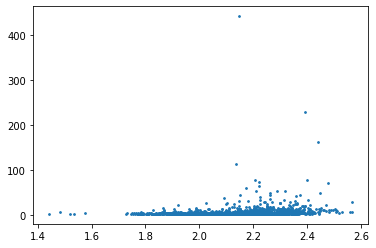

In [14]:
plt.scatter(head_norm, num_children, s=3.)
